<a href="https://colab.research.google.com/github/SoyMilkQwQ/229352-StatisticalLearning-or-Statistical-Learning-Labs-qxq./blob/main/Lab01_CDF_estimate_660510751.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

660510751 กิตติพล



### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #1

# Cumulative Distribution Function (CDF) Estimation

## 1. Estimate the CDF from the sample using EDF

In [20]:
# @title
# --- Block 1: Setup & Interactive ECDF vs. True CDF ---

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, integrate
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Configuration ---
TRUE_DISTRIBUTION_MEAN = 2
TRUE_DISTRIBUTION_STD_DEV = 1
INITIAL_NUM_SAMPLES = 3 # Starting points for ECDF
SAMPLES_PER_CLICK_ECDF = 5 # Points added to ECDF per 'Add Samples' click (Block 1)
NUM_SAMPLES_FOR_HISTOGRAMS = 5000 # Number of samples to draw for histogram comparisons (Blocks 3 & 5)
PLOT_BUFFER = 1.5 # X-axis buffer for plots
KDE_NUM_POINTS = 500 # Number of points to evaluate KDE/smoothed CDF over

# --- Matplotlib Global Style Configuration ---
plt.rcParams.update({'font.size': 14}) # Base font size
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12

# --- Global Data Storage and State ---
current_data_points = [] # The original data points from true distribution

# --- Helper Functions (Defined once, used by all blocks) ---

def calculate_ecdf_plot_points(data, x_plot_min, x_plot_max):
    """
    Calculates x and y coordinates for plotting the ECDF,
    extending it from 0 to 1 across the plot's x-range.
    """
    if not data:
        # Return empty arrays, but still define the range for consistency
        return np.array([x_plot_min, x_plot_max]), np.array([0, 1])

    sorted_data = np.sort(data)
    n = len(sorted_data)

    y_ecdf_core = np.arange(1, n + 1) / n

    # Extend ECDF to start at 0 and end at 1 across the plot's x-range
    # Prepend a point: (x_plot_min, 0)
    x_ecdf_extended = np.insert(sorted_data, 0, x_plot_min)
    y_ecdf_extended = np.insert(y_ecdf_core, 0, 0)
    # Append a point: (x_plot_max, 1)
    x_ecdf_extended = np.append(x_ecdf_extended, x_plot_max)
    y_ecdf_extended = np.append(y_ecdf_extended, 1)

    return x_ecdf_extended, y_ecdf_extended

def sample_from_ecdf(data, num_samples=None, uniform_draws=None):
    """
    Generates samples from the ECDF using inverse transform sampling.
    For a uniform random variable u, the sample is the k-th smallest data point
    where k = ceil(n * u).
    If uniform_draws is provided, uses those; otherwise, generates num_samples.
    """
    if not data:
        return np.array([])
    sorted_data = np.sort(data)
    n = len(sorted_data)

    if n == 0:
        return np.array([])

    if uniform_draws is None:
        if num_samples is None:
            raise ValueError("Either num_samples or uniform_draws must be provided.")
        uniform_samples = np.random.rand(num_samples)
    else:
        uniform_samples = np.asarray(uniform_draws) # Ensure it's an array

    # Calculate the index k = ceil(n * u)
    # np.ceil returns floats, convert to int for indexing
    # Subtract 1 because Python indexing is 0-based for arrays
    # Handle u=0 edge case: ceil(n*0) = 0, so index becomes -1. This should map to index 0 (first element).
    indices = np.ceil(n * uniform_samples).astype(int) - 1
    indices[indices < 0] = 0 # Ensures uniform_draws=0 maps to the first data point

    sampled_values = sorted_data[indices]

    return sampled_values

def get_smoothed_cdf_and_x_range(data, true_mean, true_std_dev):
    """
    Calculates a smoothed CDF using KDE from the given data.
    Returns the x_range for plotting and the corresponding smoothed CDF values.
    """
    if len(data) < 2: # KDE needs at least 2 points
        # If not enough data, return a default range and the true CDF as a fallback
        min_val = true_mean - 3 * true_std_dev
        max_val = true_mean + 3 * true_std_dev
        x_range = np.linspace(min_val - PLOT_BUFFER, max_val + PLOT_BUFFER, KDE_NUM_POINTS)
        return x_range, stats.norm.cdf(x_range, loc=true_mean, scale=true_std_dev)

    min_val_data = np.min(data)
    max_val_data = np.max(data)
    x_range = np.linspace(min_val_data - PLOT_BUFFER, max_val_data + PLOT_BUFFER, KDE_NUM_POINTS)

    kde = stats.gaussian_kde(data)
    pdf_vals = kde.evaluate(x_range)

    # Numerically integrate the PDF to get the CDF
    cdf_vals = integrate.cumulative_trapezoid(pdf_vals, x_range, initial=0)
    if cdf_vals[-1] != 0:
        cdf_vals = cdf_vals / cdf_vals[-1] # Ensure it ends at 1
    else: # Fallback if integration results in all zeros (e.g., all data points are identical)
        cdf_vals = np.zeros_like(cdf_vals)
        if len(cdf_vals) > 0: cdf_vals[-1] = 1.0 # Force last point to 1 if possible

    return x_range, cdf_vals

def sample_from_smoothed_cdf(x_range, smoothed_cdf_vals, num_samples):
    """
    Generates samples from the smoothed CDF using inverse transform sampling.
    """
    if len(x_range) < 2 or len(smoothed_cdf_vals) < 2:
        return np.array([])
    uniform_samples = np.random.rand(num_samples)
    sampled_values = np.interp(uniform_samples, smoothed_cdf_vals, x_range)
    return sampled_values

# --- Initialization of current_data_points (for all blocks) ---
def initialize_data():
    global current_data_points
    np.random.seed(42) # For reproducibility of initial data
    current_data_points = stats.norm.rvs(
        loc=TRUE_DISTRIBUTION_MEAN,
        scale=TRUE_DISTRIBUTION_STD_DEV,
        size=INITIAL_NUM_SAMPLES
    ).tolist()
    current_data_points.sort()

initialize_data() # Call to set up initial data

# --- Plotting Function for Block 1 ---
def plot_ecdf_vs_true_cdf():
    fig, ax = plt.subplots(figsize=(10, 6))

    if current_data_points:
        min_val_data = np.min(current_data_points)
        max_val_data = np.max(current_data_points)
    else:
        min_val_data = TRUE_DISTRIBUTION_MEAN - 3 * TRUE_DISTRIBUTION_STD_DEV
        max_val_data = TRUE_DISTRIBUTION_MEAN + 3 * TRUE_DISTRIBUTION_STD_DEV
    x_plot_min = min_val_data - PLOT_BUFFER
    x_plot_max = max_val_data + PLOT_BUFFER
    x_vals_plot_range = np.linspace(x_plot_min, x_plot_max, KDE_NUM_POINTS)

    # True CDF
    y_vals_true_cdf = stats.norm.cdf(x_vals_plot_range, loc=TRUE_DISTRIBUTION_MEAN, scale=TRUE_DISTRIBUTION_STD_DEV)
    ax.plot(x_vals_plot_range, y_vals_true_cdf,
            label=f'True CDF (Normal({TRUE_DISTRIBUTION_MEAN}, {TRUE_DISTRIBUTION_STD_DEV}))',
            color='green', linewidth=3)

    # ECDF
    x_ecdf, y_ecdf = calculate_ecdf_plot_points(current_data_points, x_plot_min, x_plot_max)
    ax.step(x_ecdf, y_ecdf, where='post',
            label=f'ECDF (n={len(current_data_points)} samples)',
            color='red', linestyle='--', linewidth=2)

    # Plot individual data points
    if current_data_points:
        ax.scatter(current_data_points, np.zeros_like(current_data_points),
                   marker='|', color='gray', s=150, zorder=5, label='Data Points')

    ax.set_title('Interactive ECDF vs. True CDF')
    ax.set_xlabel('Value (X)')
    ax.set_ylabel('P(X <= x)')
    ax.legend(loc='upper left')
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(x_plot_min, x_plot_max)
    plt.tight_layout()
    plt.show()

# --- Interactive Elements for Block 1 ---
block1_output = widgets.Output()
add_samples_button_block1 = widgets.Button(description=f"Add {SAMPLES_PER_CLICK_ECDF} New Samples to ECDF")
reset_data_button_block1 = widgets.Button(description="Reset Data to Initial")

def on_add_samples_block1_clicked(b):
    global current_data_points
    new_samples = stats.norm.rvs(
        loc=TRUE_DISTRIBUTION_MEAN,
        scale=TRUE_DISTRIBUTION_STD_DEV,
        size=SAMPLES_PER_CLICK_ECDF
    )
    current_data_points.extend(new_samples.tolist())
    current_data_points.sort()
    with block1_output:
        clear_output(wait=True)
        plot_ecdf_vs_true_cdf()

def on_reset_data_block1_clicked(b):
    initialize_data() # Reset global data points
    with block1_output:
        clear_output(wait=True)
        plot_ecdf_vs_true_cdf()

add_samples_button_block1.on_click(on_add_samples_block1_clicked)
reset_data_button_block1.on_click(on_reset_data_block1_clicked)

print("Block 1: Visualize the ECDF and how it converges to the True CDF.")
display(widgets.HBox([add_samples_button_block1, reset_data_button_block1]), block1_output)

# Initial display for Block 1
with block1_output:
    plot_ecdf_vs_true_cdf()

Block 1: Visualize the ECDF and how it converges to the True CDF.


Output()

## 2. Sample from the EDF using Inverse CDF sampling

In [21]:
# @title
# --- Block 2: Interactive Inverse CDF Sampling Illustration ---

# Global variable for samples collected in this specific illustration
# Will store (uniform_value, sampled_x_value) tuples
ecdf_illustration_samples = []

def plot_inverse_cdf_illustration():
    fig, (ax_cdf, ax_hist) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

    # Determine plot X-range based on current_data_points
    if current_data_points:
        min_val_data = np.min(current_data_points)
        max_val_data = np.max(current_data_points)
    else:
        min_val_data = TRUE_DISTRIBUTION_MEAN - 3 * TRUE_DISTRIBUTION_STD_DEV
        max_val_data = TRUE_DISTRIBUTION_MEAN + 3 * TRUE_DISTRIBUTION_STD_DEV

    x_plot_min = min_val_data - PLOT_BUFFER
    x_plot_max = max_val_data + PLOT_BUFFER
    x_vals_plot_range = np.linspace(x_plot_min, x_plot_max, KDE_NUM_POINTS)

    # --- Left Plot (ECDF and Sampling) ---
    # True CDF (for context)
    y_vals_true_cdf = stats.norm.cdf(x_vals_plot_range, loc=TRUE_DISTRIBUTION_MEAN, scale=TRUE_DISTRIBUTION_STD_DEV)
    ax_cdf.plot(x_vals_plot_range, y_vals_true_cdf,
                label=f'True CDF', color='green', linewidth=1.5, alpha=0.5)

    # ECDF
    x_ecdf, y_ecdf = calculate_ecdf_plot_points(current_data_points, x_plot_min, x_plot_max)
    ax_cdf.step(x_ecdf, y_ecdf, where='post',
                label=f'ECDF (n={len(current_data_points)} samples)',
                color='red', linestyle='-', linewidth=2)

    # Plot individual data points (on the x-axis)
    if current_data_points:
        ax_cdf.scatter(current_data_points, np.zeros_like(current_data_points),
                       marker='|', color='gray', s=100, zorder=5, label='Data Points')

    # Add the current sample illustration if there are samples
    if ecdf_illustration_samples:
        # Get the last sampled uniform value and corresponding x_value
        last_uniform_val, last_sampled_x = ecdf_illustration_samples[-1] # Get from stored tuple

        # Draw horizontal line from y-axis to the sampled point's x-value
        ax_cdf.plot([x_plot_min, last_sampled_x], [last_uniform_val, last_uniform_val],
                    color='green', linestyle=':', linewidth=1.5, label='Uniform Draw (u)')
        # Draw vertical line from the uniform draw level down to x-axis at sampled_x
        ax_cdf.plot([last_sampled_x, last_sampled_x], [0, last_uniform_val],
                    color='green', linestyle=':', linewidth=1.5)
        # Mark the sampled point on x-axis
        ax_cdf.plot(last_sampled_x, 0, marker='o', color='green', markersize=8,
                    label=f'Sampled X: {last_sampled_x:.2f}')
        ax_cdf.set_title(f'Inverse CDF Sampling (u={last_uniform_val:.2f})')
    else:
        ax_cdf.set_title('Inverse CDF Sampling (Draw a Sample)')

    ax_cdf.set_xlabel('Value (X)')
    ax_cdf.set_ylabel('P(X <= x) / Uniform (u)')
    ax_cdf.legend(loc='upper left')
    ax_cdf.grid(True, linestyle=':', alpha=0.7)
    ax_cdf.set_ylim(0, 1.05)
    ax_cdf.set_xlim(x_plot_min, x_plot_max)

    # --- Right Plot (Histogram of Drawn Values) ---
    ax_hist.set_title('Histogram of ECDF Samples')
    ax_hist.set_xlabel('Value (X)')
    ax_hist.set_ylabel('Density')

    if ecdf_illustration_samples:
        # Extract only the x_values for the histogram
        x_values_for_hist = [item[1] for item in ecdf_illustration_samples]
        bins = np.linspace(x_plot_min, x_plot_max, 30) # Use consistent bins
        ax_hist.hist(x_values_for_hist, bins=bins, density=True, color='orange', alpha=0.7)
        ax_hist.set_title(f'Histogram of ECDF Samples (n={len(x_values_for_hist)})')
    else:
        ax_hist.text(0.5, 0.5, 'Click "Draw Sample" to begin',
                     horizontalalignment='center', verticalalignment='center',
                     transform=ax_hist.transAxes, fontsize=12, color='gray')
    ax_hist.grid(True, linestyle=':', alpha=0.7)
    ax_hist.set_xlim(x_plot_min, x_plot_max) # Keep x-axis consistent

    plt.tight_layout()
    plt.show()

# --- Interactive Elements for Block 2 ---
block2_output = widgets.Output()
draw_sample_button = widgets.Button(description="Draw 1 Sample (Illustrate)")
reset_illustration_button = widgets.Button(description="Reset Samples")

def on_draw_sample_clicked(b):
    global ecdf_illustration_samples
    if not current_data_points:
        with block2_output: clear_output(wait=True); display(widgets.HTML("<b>Please add samples in Block 1 first.</b>"))
        return

    # Generate one uniform value
    uniform_val = np.random.rand(1)[0]
    # Use this uniform_val to get the corresponding sampled x_value
    sampled_x_val = sample_from_ecdf(current_data_points, uniform_draws=[uniform_val])[0]

    ecdf_illustration_samples.append((uniform_val, sampled_x_val)) # Store the tuple
    with block2_output:
        clear_output(wait=True)
        plot_inverse_cdf_illustration()

def on_reset_illustration_clicked(b):
    global ecdf_illustration_samples
    ecdf_illustration_samples = [] # Clear samples
    with block2_output:
        clear_output(wait=True)
        plot_inverse_cdf_illustration()

draw_sample_button.on_click(on_draw_sample_clicked)
reset_illustration_button.on_click(on_reset_illustration_clicked)

print("Block 2: Illustrate Inverse CDF Sampling from the ECDF.")
print("The data for the ECDF is taken from Block 1. Add more data in Block 1 to see its effect here.")
display(widgets.HBox([draw_sample_button, reset_illustration_button]), block2_output)

# Initial display for Block 2
with block2_output:
    plot_inverse_cdf_illustration()

Block 2: Illustrate Inverse CDF Sampling from the ECDF.
The data for the ECDF is taken from Block 1. Add more data in Block 1 to see its effect here.


Output()

## 3. Compare the histograms of samples from EDF and true CDF

In [22]:
# @title
# --- Block 3: Comparison of Histograms (ECDF Samples vs. True CDF Samples) ---

def plot_ecdf_histogram_comparison():
    # Ensure a sufficient number of samples are drawn for a meaningful histogram
    if not current_data_points:
        with block3_output: clear_output(wait=True); display(widgets.HTML("<b>No data points available from Block 1 to plot histograms.</b>"))
        return

    ecdf_sampled_data = sample_from_ecdf(current_data_points, num_samples=NUM_SAMPLES_FOR_HISTOGRAMS)
    true_cdf_sampled_data = stats.norm.rvs(
        loc=TRUE_DISTRIBUTION_MEAN,
        scale=TRUE_DISTRIBUTION_STD_DEV,
        size=NUM_SAMPLES_FOR_HISTOGRAMS
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True, sharex=True)

    # Determine common bins and x-range
    all_samples = np.concatenate([ecdf_sampled_data, true_cdf_sampled_data])
    min_val_hist = np.min(all_samples)
    max_val_hist = np.max(all_samples)
    bins = np.linspace(min_val_hist, max_val_hist, 50)

    # Histogram from ECDF samples
    ax1.hist(ecdf_sampled_data, bins=bins, density=True, alpha=0.7, color='red',
             label=f'From ECDF (n_orig={len(current_data_points)})')
    ax1.set_title('Samples from ECDF')
    ax1.set_xlabel('Value (X)')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.7)

    # Histogram from True CDF samples
    ax2.hist(true_cdf_sampled_data, bins=bins, density=True, alpha=0.7, color='green',
             label=f'From True CDF (N={TRUE_DISTRIBUTION_MEAN}, S={TRUE_DISTRIBUTION_STD_DEV})')
    ax2.set_title('Samples from True CDF')
    ax2.set_xlabel('Value (X)')
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.7)

    plt.suptitle(f'Block 3: Comparing Sample Distributions ({NUM_SAMPLES_FOR_HISTOGRAMS} samples each)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Interactive Elements for Block 3 ---
block3_output = widgets.Output()
refresh_hist_button_block3 = widgets.Button(description="Refresh Histograms")

def on_refresh_hist_block3_clicked(b):
    with block3_output:
        clear_output(wait=True)
        plot_ecdf_histogram_comparison()

refresh_hist_button_block3.on_click(on_refresh_hist_block3_clicked)

print("Block 3: Compare samples generated from the ECDF to samples from the True CDF.")
print("Click 'Refresh Histograms' to update based on current data from Block 1.")
display(refresh_hist_button_block3, block3_output)

# Initial display for Block 3
with block3_output:
    plot_ecdf_histogram_comparison()

Block 3: Compare samples generated from the ECDF to samples from the True CDF.
Click 'Refresh Histograms' to update based on current data from Block 1.


Button(description='Refresh Histograms', style=ButtonStyle())

Output()

## 4. Smooth the EDF

In [23]:
# @title
# --- Block 4: Plot of ECDF, Smoothed ECDF, and True CDF ---

def plot_smoothed_cdfs():
    fig, ax = plt.subplots(figsize=(10, 6))

    if current_data_points:
        min_val_data = np.min(current_data_points)
        max_val_data = np.max(current_data_points)
    else:
        min_val_data = TRUE_DISTRIBUTION_MEAN - 3 * TRUE_DISTRIBUTION_STD_DEV
        max_val_data = TRUE_DISTRIBUTION_MEAN + 3 * TRUE_DISTRIBUTION_STD_DEV
    x_plot_min = min_val_data - PLOT_BUFFER
    x_plot_max = max_val_data + PLOT_BUFFER
    x_vals_plot_range = np.linspace(x_plot_min, x_plot_max, KDE_NUM_POINTS)

    # True CDF
    y_vals_true_cdf = stats.norm.cdf(x_vals_plot_range, loc=TRUE_DISTRIBUTION_MEAN, scale=TRUE_DISTRIBUTION_STD_DEV)
    ax.plot(x_vals_plot_range, y_vals_true_cdf,
            label=f'True CDF (Normal({TRUE_DISTRIBUTION_MEAN}, {TRUE_DISTRIBUTION_STD_DEV}))',
            color='green', linewidth=3)

    # Original ECDF (as context)
    x_ecdf, y_ecdf = calculate_ecdf_plot_points(current_data_points, x_plot_min, x_plot_max)
    ax.step(x_ecdf, y_ecdf, where='post',
            label=f'Original ECDF (n={len(current_data_points)} samples)',
            color='red', linestyle=':', linewidth=1.5, alpha=0.7)

    # Smoothed CDF
    x_smoothed_cdf, y_smoothed_cdf = get_smoothed_cdf_and_x_range(current_data_points, TRUE_DISTRIBUTION_MEAN, TRUE_DISTRIBUTION_STD_DEV)
    ax.plot(x_smoothed_cdf, y_smoothed_cdf,
            label='Smoothed ECDF (KDE)',
            color='blue', linewidth=3, linestyle='-')

    ax.set_title('Block 4: Smoothed Empirical CDF')
    ax.set_xlabel('Value (X)')
    ax.set_ylabel('P(X <= x)')
    ax.legend(loc='upper left')
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(x_plot_min, x_plot_max)
    plt.tight_layout()
    plt.show()

# --- Interactive Elements for Block 4 ---
block4_output = widgets.Output()
refresh_smoothed_cdf_button = widgets.Button(description="Refresh Smoothed CDF")

def on_refresh_smoothed_cdf_clicked(b):
    with block4_output:
        clear_output(wait=True)
        plot_smoothed_cdfs()

refresh_smoothed_cdf_button.on_click(on_refresh_smoothed_cdf_clicked)

print("Block 4: Visualize the ECDF, its smoothed version (using KDE), and the True CDF.")
print("Click 'Refresh Smoothed CDF' to update based on current data from Block 1.")
display(refresh_smoothed_cdf_button, block4_output)

# Initial display for Block 4
with block4_output:
    plot_smoothed_cdfs()

Block 4: Visualize the ECDF, its smoothed version (using KDE), and the True CDF.
Click 'Refresh Smoothed CDF' to update based on current data from Block 1.


Button(description='Refresh Smoothed CDF', style=ButtonStyle())

Output()

## 5. Compare the histograms of samples from smoothed EDF and true CDF

In [39]:
# @title
# --- Block 5: Comparison of Histograms (Smoothed ECDF Samples vs. True CDF Samples) ---

def plot_smoothed_ecdf_histogram_comparison():
    if not current_data_points:
        with block5_output: clear_output(wait=True); display(widgets.HTML("<b>No data points available from Block 1 to plot histograms.</b>"))
        return

    x_smoothed_cdf, y_smoothed_cdf = get_smoothed_cdf_and_x_range(current_data_points, TRUE_DISTRIBUTION_MEAN, TRUE_DISTRIBUTION_STD_DEV)
    smoothed_ecdf_sampled_data = sample_from_smoothed_cdf(x_smoothed_cdf, y_smoothed_cdf, NUM_SAMPLES_FOR_HISTOGRAMS)

    true_cdf_sampled_data = stats.norm.rvs(
        loc=TRUE_DISTRIBUTION_MEAN,
        scale=TRUE_DISTRIBUTION_STD_DEV,
        size=NUM_SAMPLES_FOR_HISTOGRAMS
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True, sharex=True)

    # Determine common bins and x-range
    all_samples = np.concatenate([smoothed_ecdf_sampled_data, true_cdf_sampled_data])
    min_val_hist = np.min(all_samples)
    max_val_hist = np.max(all_samples)
    bins = np.linspace(min_val_hist, max_val_hist, 50)

    # Histogram from Smoothed ECDF samples
    ax1.hist(smoothed_ecdf_sampled_data, bins=bins, density=True, alpha=0.7, color='red',
             label=f'From Smoothed ECDF (n_orig={len(current_data_points)})')
    ax1.set_title('Samples from Smoothed ECDF')
    ax1.set_xlabel('Value (X)')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.7)

    # Histogram from True CDF samples
    ax2.hist(true_cdf_sampled_data, bins=bins, density=True, alpha=0.7, color='blue',
             label=f'From True CDF (N={TRUE_DISTRIBUTION_MEAN}, S={TRUE_DISTRIBUTION_STD_DEV})')
    ax2.set_title('Samples from True CDF')
    ax2.set_xlabel('Value (X)')
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.7)

    plt.suptitle(f'Block 5: Comparing Sample Distributions ({NUM_SAMPLES_FOR_HISTOGRAMS} samples each)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Interactive Elements for Block 5 ---
block5_output = widgets.Output()
refresh_smoothed_hist_button = widgets.Button(description="Refresh Smoothed Histograms")

def on_refresh_smoothed_hist_clicked(b):
    with block5_output:
        clear_output(wait=True)
        plot_smoothed_ecdf_histogram_comparison()

refresh_smoothed_hist_button.on_click(on_refresh_smoothed_hist_clicked)

print("Block 5: Compare samples generated from the Smoothed ECDF to samples from the True CDF.")
print("Click 'Refresh Smoothed Histograms' to update based on current data from Block 1.")
display(refresh_smoothed_hist_button, block5_output)

# Initial display for Block 5
with block5_output:
    plot_smoothed_ecdf_histogram_comparison()

Block 5: Compare samples generated from the Smoothed ECDF to samples from the True CDF.
Click 'Refresh Smoothed Histograms' to update based on current data from Block 1.


Button(description='Refresh Smoothed Histograms', style=ButtonStyle())

Output()

# Review numpy

## 1. 1D and 2D array

In [25]:
a = np.array([1, 2, 3])
A = np.array([[1, 2, 3], [4, 5, 6],[7, 8, 9]])

## 2. Indexing

In [26]:
A[1, 2]

np.int64(6)

In [27]:
A[:,2]

array([3, 6, 9])

In [28]:
A[:-1,2]

array([3, 6])

In [29]:
A[0,:]

array([1, 2, 3])

In [30]:
A[-2:,:2]

array([[4, 5],
       [7, 8]])

## 3. Mathematical operations

In [31]:
B = 2*A
B+A

array([[ 3,  6,  9],
       [12, 15, 18],
       [21, 24, 27]])

In [32]:
b = np.array([10, 100, 1000])
b[None, :]
b[:, None]
A+b[None,:]
A+b[:,None]

array([[  11,   12,   13],
       [ 104,  105,  106],
       [1007, 1008, 1009]])

## 4. Boolean operation

In [33]:
A >= 5

array([[False, False, False],
       [False,  True,  True],
       [ True,  True,  True]])

## 5. Boolean indexing

In [34]:
A[A>=5]

array([5, 6, 7, 8, 9])

# Exercise: Robust mean estimation

The goal of this exercise is to develop a method to estimate the mean of the distribution in presence of outliers.

Below, we generate some data from a normal distribution with mean = 50; however, the data has been contaminated with some outliers. Your task is to implement a function that takes the numpy array of contaminated data and returns your estimate of the mean of the normal distribution.

Generated 100 data points from a fixed seed (42).
90 normal samples, 10 outliers.
True mean of the *uncontaminated* normal distribution: 50.00


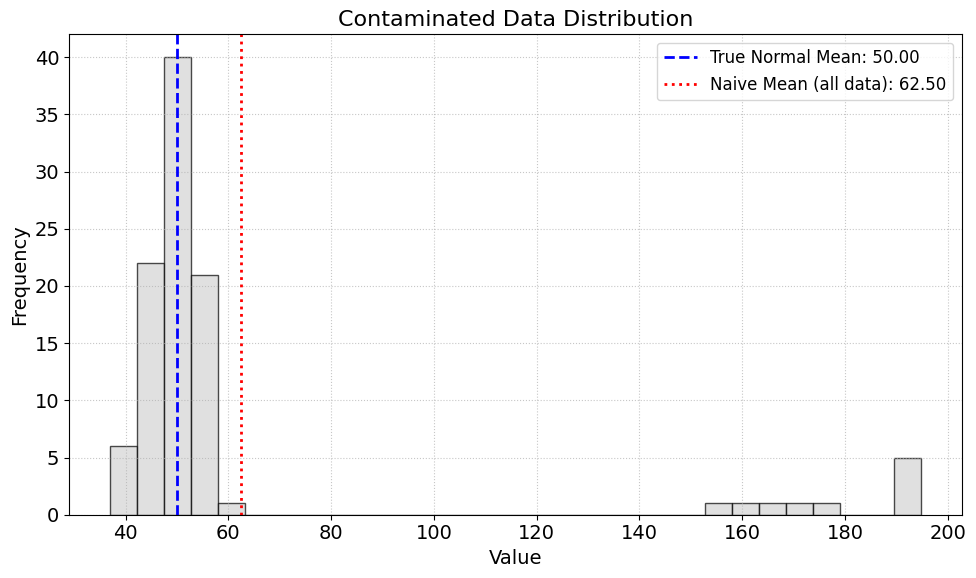

In [35]:
# @title
# --- Configuration for Data Generation ---
TRUE_NORMAL_MEAN = 50.0       # The true mean of the underlying normal distribution
TRUE_NORMAL_STD_DEV = 5.0    # The true standard deviation of the underlying normal distribution
NUM_SAMPLES = 100            # Total number of data points
OUTLIER_PERCENTAGE = 0.10    # 10% of the data will be outliers
OUTLIER_MIN_VAL = 150.0      # Minimum value for the large outliers
OUTLIER_MAX_VAL = 200.0      # Maximum value for the large outliers
FIXED_SEED = 42              # Fixed seed for reproducible data generation

contaminated_data = np.array([])

# --- Data Generation Function ---
def generate_contaminated_data(seed=None):
    """
    Generates data from a normal distribution with a percentage of extreme outliers.
    """

    np.random.seed(seed) # Set the seed for reproducibility

    num_outliers = int(NUM_SAMPLES * OUTLIER_PERCENTAGE)
    num_normal_samples = NUM_SAMPLES - num_outliers

    # Generate normal data
    normal_samples = np.random.normal(TRUE_NORMAL_MEAN, TRUE_NORMAL_STD_DEV, num_normal_samples)

    # Generate outlier data (explicitly very large values)
    outliers = np.random.uniform(OUTLIER_MIN_VAL, OUTLIER_MAX_VAL, num_outliers)

    # Combine and shuffle the data
    contaminated_data = np.concatenate((normal_samples, outliers))
    np.random.shuffle(contaminated_data)

    print(f"Generated {NUM_SAMPLES} data points from a fixed seed ({seed}).")
    print(f"{num_normal_samples} normal samples, {num_outliers} outliers.")
    print(f"True mean of the *uncontaminated* normal distribution: {TRUE_NORMAL_MEAN:.2f}")

    return contaminated_data

# --- Plotting Function ---
def plot_data(contaminated_data):
    fig, ax = plt.subplots(figsize=(10, 6))

    if contaminated_data.size == 0:
        ax.text(0.5, 0.5, "No data generated. Run the cell above to generate data.",
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=16, color='gray')
        ax.set_title("Data Preview")
        ax.set_xlabel("Value")
        ax.set_ylabel("Count")
        plt.show()
        return

    ax.hist(contaminated_data, bins=30, density=False, alpha=0.7, color='lightgray', edgecolor='black')
    ax.axvline(TRUE_NORMAL_MEAN, color='blue', linestyle='--', linewidth=2, label=f'True Normal Mean: {TRUE_NORMAL_MEAN:.2f}')

    # Also show the naive mean calculation as a comparison
    naive_mean = np.mean(contaminated_data)
    ax.axvline(naive_mean, color='red', linestyle=':', linewidth=2, label=f'Naive Mean (all data): {naive_mean:.2f}')


    ax.set_title('Contaminated Data Distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()


contaminated_data = generate_contaminated_data(seed=FIXED_SEED)
plot_data(contaminated_data)

In [36]:
contaminated_data

array([ 46.99146694,  45.80391238,  40.43359878,  50.85684141,
        53.83717365,  57.32824384, 194.804565  ,  57.61514928,
        51.71809145,  41.37541084,  48.50496325,  51.20981136,
        54.87772564, 171.35538943,  54.11272456,  47.49121478,
        50.98430618,  47.60412881,  57.38947022,  44.01896688,
        46.40077896, 190.9007383 ,  54.06262911,  53.6923329 ,
       193.03652916,  41.18479922,  51.78556286,  49.42175859,
        52.71280022,  48.54153125,  50.33764102, 165.90017375,
        47.27808638,  51.87849009,  56.78120014,  57.82321828,
        51.57123666,  51.80697803,  57.89606408,  55.01766449,
        47.69680615,  42.60739005,  49.63994939,  50.55461295,
        49.8208698 ,  43.89578175,  42.93848149,  40.06215543,
        46.99680655,  36.90127448,  45.95753199, 161.39675813,
        49.93251388,  47.18856235,  55.28561113,  47.68291154,
        48.8711185 ,  48.82931522,  44.71144536,  47.40864891,
        48.82923313, 176.9671121 ,  40.20164938,  44.46

In [37]:
# INSTRUCTIONS: Implement the `estimate_mean` function below.

def estimate_mean(data):
    """
    Estimates the mean of an underlying normal distribution from contaminated data.

    Args:
        data (np.array or list): A 1D array of numerical data, potentially containing outliers.

    Returns:
        float: Your robust estimate of the mean of the normal distribution.
    """
    # --- YOUR CODE GOES HERE ---
    # Placeholder: Replace this with your robust mean estimation method
    estimated_mean = np.mean(data)


    return float(estimated_mean)

In [38]:
# Evaluation

estimated_mean = estimate_mean(contaminated_data)
absolute_error = abs(estimated_mean - TRUE_NORMAL_MEAN)
print(f"Estimated Mean: {estimated_mean:.2f}")
print(f"Absolute Error: {absolute_error:.2f}")

Estimated Mean: 62.50
Absolute Error: 12.50


## Please explain the idea behind your estimation method in the text block below:

Answer:

เนื่องจาก ข้อมูลมี outlier การหาmean ก็เลยจะถูก outlier ดึงให้เพี้ยนไป

1. ใช้ค่า median แทน mean ชั่วคราว

2. ใช้ MAD

3. กรองข้อมูล outlier ออก

4. คำนวณค่าเฉลี่ยจากข้อมูลที่กรองแล้ว
